<a href="https://colab.research.google.com/github/codelspak/Struggles/blob/main/WK31_Case1_ML_Prediction_Sales_of_each_shops.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 쇼핑몰 지점별 매출액 예측 
- 심사 기준 : RMSE<br>

[데이콘 경진대회 링크](https://dacon.io/competitions/official/235942/data)

# 1. 라이브러리 및 데이터 불러오기

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# !unzip dataset.zip

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [ ]:
train.shape, test.shape, submission.shape

((6255, 13), (180, 12), (180, 2))

In [ ]:
# 원본 사본 만들어놓음
train_ori = train.copy()
test_ori = test.copy()
submit_ori = submission.copy()

# 2. 탐색적 데이터 분석

### 2.1. 데이터 컬럼 정보
**1. train.csv : 학습 데이터**
<br>- id : 샘플 아이디
<br>- Store : 쇼핑몰 지점
<br>- Date : 주 단위(Weekly) 날짜
<br>- Temperature : 해당 쇼핑몰 주변 기온
<br>- Fuel_Price : 해당 쇼핑몰 주변 연료 가격
<br>- Promotion 1~5 : 해당 쇼핑몰의 비식별화된 프로모션 정보
<br>- Unemployment : 해당 쇼핑몰 지역의 실업률
<br>- IsHoliday : 해당 기간의 공휴일 포함 여부
<br>- Weekly_Sales : 주간 매출액 (목표 예측값)

**2. sample_submission.csv : 제출 양식**
<br>- id : 샘플 아이디
<br>- Weekly_Sales : 주간 매출액 (목표 예측값)

### 2.2. 데이터 상태 확인

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6255 entries, 0 to 6254
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            6255 non-null   int64  
 1   Store         6255 non-null   int64  
 2   Date          6255 non-null   object 
 3   Temperature   6255 non-null   float64
 4   Fuel_Price    6255 non-null   float64
 5   Promotion1    2102 non-null   float64
 6   Promotion2    1592 non-null   float64
 7   Promotion3    1885 non-null   float64
 8   Promotion4    1819 non-null   float64
 9   Promotion5    2115 non-null   float64
 10  Unemployment  6255 non-null   float64
 11  IsHoliday     6255 non-null   bool   
 12  Weekly_Sales  6255 non-null   float64
dtypes: bool(1), float64(9), int64(2), object(1)
memory usage: 592.6+ KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            180 non-null    int64  
 1   Store         180 non-null    int64  
 2   Date          180 non-null    object 
 3   Temperature   180 non-null    float64
 4   Fuel_Price    180 non-null    float64
 5   Promotion1    178 non-null    float64
 6   Promotion2    45 non-null     float64
 7   Promotion3    161 non-null    float64
 8   Promotion4    146 non-null    float64
 9   Promotion5    180 non-null    float64
 10  Unemployment  180 non-null    float64
 11  IsHoliday     180 non-null    bool   
dtypes: bool(1), float64(8), int64(2), object(1)
memory usage: 15.8+ KB


In [ ]:
# 데이터 샘플 확인
train.head(5)

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
0,1,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,8.106,False,1643690.90
1,2,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,8.106,True,1641957.44
2,3,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,8.106,False,1611968.17
3,4,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,8.106,False,1409727.59
4,5,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,8.106,False,1554806.68


In [ ]:
train.sample(5)

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
1327,1328,10,22/07/2011,88.59,3.697,NaN,NaN,NaN,NaN,NaN,8.257,False,1774342.61
2889,2890,21,09/03/2012,57.16,3.669,7379.46,190.49,4.79,479.87,7489.48,7.057,False,755084.40
5617,5618,41,11/03/2011,31.60,3.372,NaN,NaN,NaN,NaN,NaN,7.241,False,1159089.60
1990,1991,15,10/12/2010,23.97,3.255,NaN,NaN,NaN,NaN,NaN,8.067,False,847294.04
5694,5695,41,31/08/2012,71.56,3.556,17423.04,14.94,58.91,4700.30,6180.92,6.432,False,1360517.52


In [ ]:
# unique 값 확인
train.nunique()

id              6255
Store             45
Date             139
Temperature     3470
Fuel_Price       877
Promotion1      2099
Promotion2      1457
Promotion3      1562
Promotion4      1798
Promotion5      2114
Unemployment     321
IsHoliday          2
Weekly_Sales    6255
dtype: int64

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'Store'}>,
        <AxesSubplot:title={'center':'Temperature'}>],
       [<AxesSubplot:title={'center':'Fuel_Price'}>,
        <AxesSubplot:title={'center':'Promotion1'}>,
        <AxesSubplot:title={'center':'Promotion2'}>],
       [<AxesSubplot:title={'center':'Promotion3'}>,
        <AxesSubplot:title={'center':'Promotion4'}>,
        <AxesSubplot:title={'center':'Promotion5'}>],
       [<AxesSubplot:title={'center':'Unemployment'}>,
        <AxesSubplot:title={'center':'Weekly_Sales'}>, <AxesSubplot:>]],
      dtype=object)

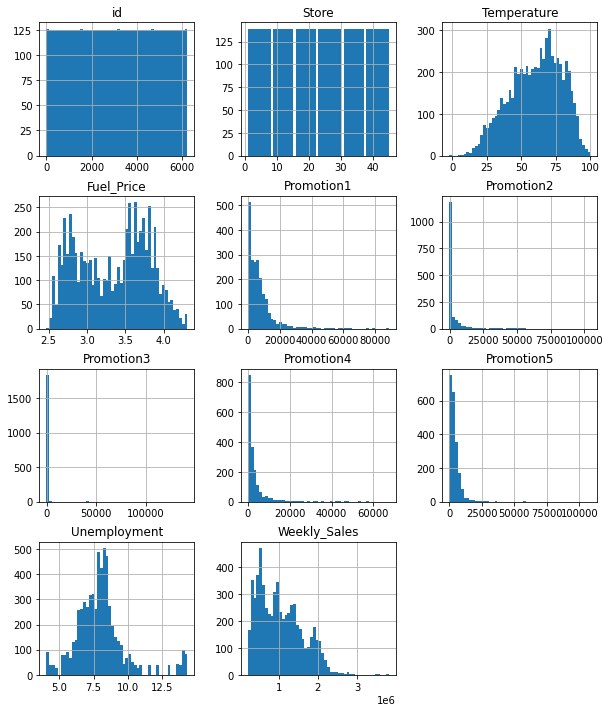

In [ ]:
# 도수분포
train.hist(bins = 50, figsize = (10, 12))

In [ ]:
# 중복 확인
train.duplicated().sum()

0

In [ ]:
# 결측치 확인
train.isnull().sum()

id                 0
Store              0
Date               0
Temperature        0
Fuel_Price         0
Promotion1      4153
Promotion2      4663
Promotion3      4370
Promotion4      4436
Promotion5      4140
Unemployment       0
IsHoliday          0
Weekly_Sales       0
dtype: int64

In [ ]:
test.isnull().sum()[test.isnull().sum()>0]

Promotion1      2
Promotion2    135
Promotion3     19
Promotion4     34
dtype: int64

In [ ]:
# 기술통계
desc = train.describe()
desc

,id,Store,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,Weekly_Sales
count,6255.000000,6255.000000,6255.000000,6255.000000,2102.000000,1592.000000,1885.000000,1819.000000,2115.000000,6255.000000,6.255000e+03
mean,3128.000000,23.000000,60.639199,3.344369,7155.930661,3308.125810,1462.535523,3465.952501,4518.993173,8.029236,1.047619e+06
std,1805.807299,12.988211,18.624094,0.455364,8408.206085,9382.823804,9667.580258,6413.116294,6048.661908,1.874875,5.654362e+05
min,1.000000,1.000000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.410000,135.160000,4.077000,2.099862e+05
25%,1564.500000,12.000000,47.170000,2.917000,1844.295000,39.755000,4.700000,499.895000,1742.305000,6.916500,5.538695e+05
50%,3128.000000,23.000000,62.720000,3.413000,5221.140000,205.410000,24.600000,1532.630000,3226.410000,7.906000,9.604761e+05
75%,4691.500000,34.000000,75.220000,3.722000,9199.242500,1931.005000,104.010000,3640.905000,5444.030000,8.622000,1.421209e+06
max,6255.000000,45.000000,100.140000,4.308000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,14.313000,3.818686e+06


In [ ]:
6255/(23*45) # 딱 안 떨어지는 걸로 보아 Store마다 샘플 수가 다름

6.043478260869565

**위 기술통계를 통해 얻은 insight, 확인 필요 포인트**
<br> 1. store마다 샘플 수가 다름 > 샘플 수는 곧 해당 주의 매출 유무와 연결되고, 따라서 꾸준히 방문하는 손님의 존재 유무로 생각
<br> 2. temperature: -2부터 100 사이 값을 가짐 > 날짜에서 계절을 파생, 계절과 연관성을 통해 단위가 C degree가 맞는지 확인
<br> 3. fuel price: 주차 별/store 별 fuel price 평균값에 차이가 있는지 확인
<br> 4-1. promotion: 결측치 너무 많음
<br> 4-2. promotion: 편차 너무 큼
<br> 4-3. promotion: 마이너스 값이 존재 
<br>      위 값을 종합해 보았을 때, promotion은 프로모션으로 인해 발생한 수익을 의미하는 것 같음
<br> 4-4. promotion: 그럼 동 기간에, 하나의 쇼핑몰은 하나의 프로모션만 진행하는지? 
<br> 5. unemployment: 얘도 min과 max의 차이가 꽤 큰 편 - 쇼핑몰 별로 차이가 있는지 확인
<br> 6. weekly sales: min과 max 값이 거의 20배 차이남 


In [ ]:
train.describe(include = ['O'])

,Date
count,6255
unique,139
top,05/02/2010
freq,45


In [ ]:
ncols = train.select_dtypes(include = 'number').columns.tolist()
df_temp = pd.DataFrame()

for col in ncols:
    col_min = desc.loc['min', col]
    df_temp[col] = train[col].map(lambda x: x - col_min if col_min<0 else x )


array([[<AxesSubplot:title={'center':'Fuel_Price'}>,
        <AxesSubplot:title={'center':'Promotion1'}>,
        <AxesSubplot:title={'center':'Promotion2'}>],
       [<AxesSubplot:title={'center':'Promotion3'}>,
        <AxesSubplot:title={'center':'Promotion4'}>,
        <AxesSubplot:title={'center':'Promotion5'}>],
       [<AxesSubplot:title={'center':'Unemployment'}>,
        <AxesSubplot:title={'center':'Weekly_Sales'}>, <AxesSubplot:>]],
      dtype=object)

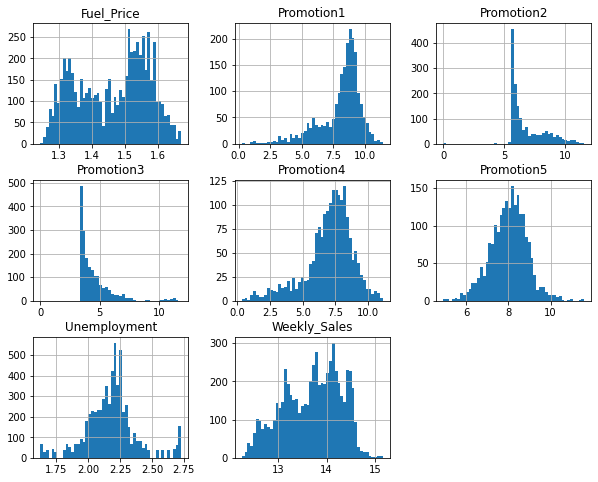

In [ ]:
# 스케일 너무 커서 로그 취한 뒤 도수분포
np.log1p(df_temp.loc[:, 'Fuel_Price':]).hist(bins = 50, figsize = (10, 8))

### 2.3. Feature engineering